In [1]:
%load_ext autoreload
%autoreload 2

from vqr.data import generate_linear_x_y_mvn_data
from vqr.api import VectorQuantileRegressor
from numpy.random import uniform, randint

In [2]:
d = 2
k = 2
n = 5000
X, Y_orig = generate_linear_x_y_mvn_data(n=n, d=d, k=k)

T = 50
vqr_ = VectorQuantileRegressor(solver_opts={"verbose": True, "num_epochs": 1000, "epsilon": 0.0001})
vqr_ = vqr_.fit(X, Y_orig)

A = vqr_._fitted_solution._A
B = vqr_._fitted_solution._B

epoch_idx=0, total_loss=2.179457 constraint_loss=2.079460
epoch_idx=100, total_loss=0.778821 constraint_loss=0.678823
epoch_idx=200, total_loss=0.620501 constraint_loss=0.520500
epoch_idx=300, total_loss=0.571204 constraint_loss=0.471204
epoch_idx=400, total_loss=0.553955 constraint_loss=0.453956
epoch_idx=500, total_loss=0.547615 constraint_loss=0.447615
epoch_idx=600, total_loss=0.544073 constraint_loss=0.444073
epoch_idx=700, total_loss=0.541564 constraint_loss=0.441564
epoch_idx=800, total_loss=0.539665 constraint_loss=0.439665
epoch_idx=900, total_loss=0.538214 constraint_loss=0.438214


In [3]:
from vqr.vqr import decode_quantile_values
from numpy import zeros, array

# Sample X, Uniformly sample U to get Y

X_new = uniform(size=[n, k]) - 0.5
Y_samp = zeros([n, d])

for i in range(X.shape[0]):
    Y_hat = (B @ X_new[i, :][:, None]) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, T), randint(0, T)
    Y_samp[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

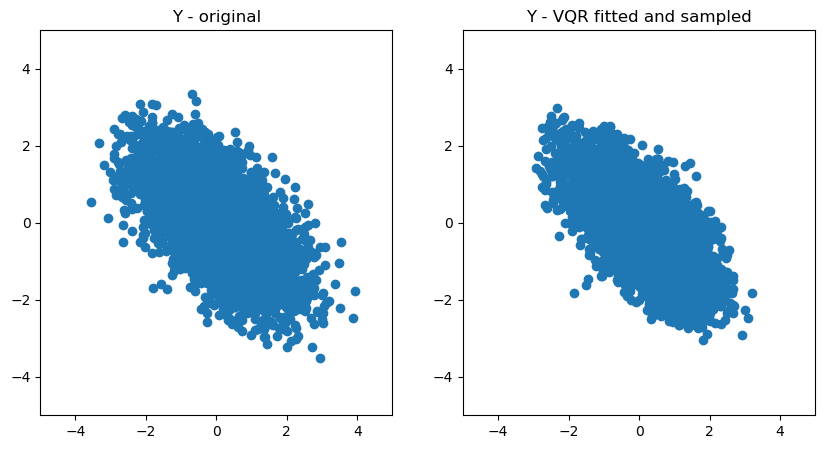

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_orig[:, 0], Y_orig[:, 1])
ax[0].set_title("Y - original")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_samp[:, 0], Y_samp[:, 1])
ax[1].set_title("Y - VQR fitted and sampled")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [5]:
# Generate a quantile function that is nonlinear in X

def g(x):
    # A nonlinear function in X
    Q = array([[10.0, 1.0], [1.0, 2.0]])
    return x.T @ Q @ x + x


Y_nl = zeros([n, d])
for i in range(n):
    # Sample using a known B but the quantile function is now nonlinear in X
    Y_hat = (B @ g(X_new[i, :][:, None])) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, 50), randint(0, 50)
    Y_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

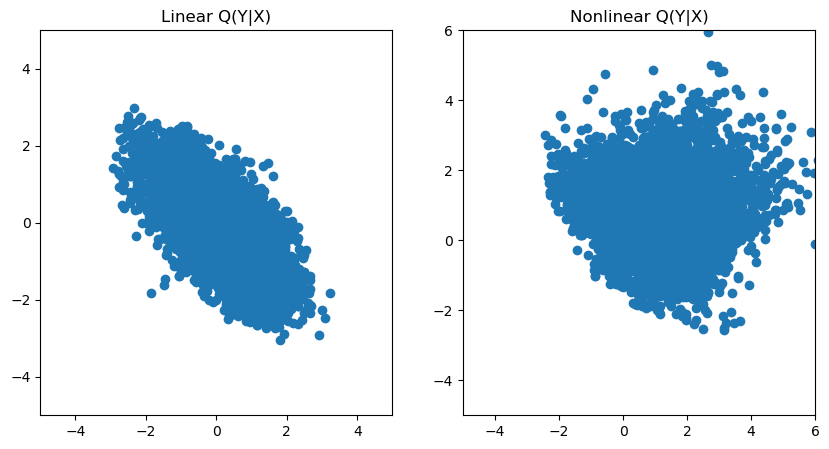

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_samp[:, 0], Y_samp[:, 1])
ax[0].set_title("Linear Q(Y|X)")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[1].set_title("Nonlinear Q(Y|X)")
ax[1].set_xlim(-5, 6)
ax[1].set_ylim(-5, 6)

plt.show()

In [7]:
# We know that the distribution on the right has a nonlinear quantile function w.r.to X. 
# Now we fit a VQR on this data to get a linear approximation of this nonlinear function.
# This allows us to measure how mis-specified is the quantile function

vqr_approximating_nl = VectorQuantileRegressor(
    solver_opts={"verbose": True, "num_epochs": 1000, "epsilon": 0.001}
)
vqr_approximating_nl = vqr_approximating_nl.fit(X_new, Y_nl)
B_approximating_nl = vqr_approximating_nl._fitted_solution._B
A_approximating_nl = vqr_approximating_nl._fitted_solution._A


epoch_idx=0, total_loss=5.262447 constraint_loss=5.162451
epoch_idx=100, total_loss=2.304433 constraint_loss=2.204436
epoch_idx=200, total_loss=1.940180 constraint_loss=1.840177
epoch_idx=300, total_loss=1.779992 constraint_loss=1.679991
epoch_idx=400, total_loss=1.697104 constraint_loss=1.597104
epoch_idx=500, total_loss=1.655318 constraint_loss=1.555318
epoch_idx=600, total_loss=1.636680 constraint_loss=1.536680
epoch_idx=700, total_loss=1.629622 constraint_loss=1.529622
epoch_idx=800, total_loss=1.626991 constraint_loss=1.526991
epoch_idx=900, total_loss=1.625911 constraint_loss=1.525911


In [8]:
Y_approximated_nl = zeros([n, d])
for i in range(n):
    # Y_hat = (B_approximating_nl @ g(X_new[i, :][:, None])) + A_approximating_nl
    Y_hat = (B_approximating_nl @ X_new[i, :][:, None]) + A_approximating_nl
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, 50), randint(0, 50)
    Y_approximated_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

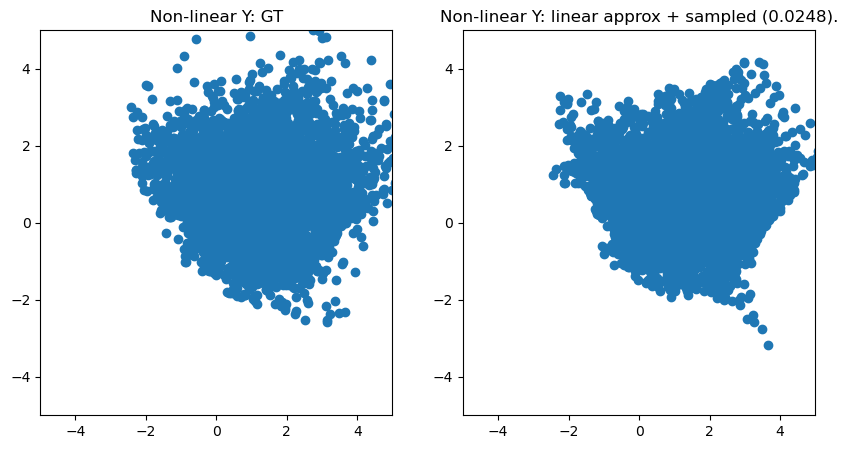

In [16]:
import ot
def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=4
    )

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[0].set_title("Non-linear Y: GT")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_approximated_nl[:, 0], Y_approximated_nl[:, 1])
ax[1].set_title(f"Non-linear Y: linear approx + sampled ({w2(Y_nl, Y_approximated_nl):.4f}).")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [10]:
from numpy import stack

nonlinear_vqr_gt = VectorQuantileRegressor(solver_opts={"verbose": True, "num_epochs": 1000, "epsilon": 0.001})
nonlinear_vqr_gt = nonlinear_vqr_gt.fit(
    stack([g(X_new[i, :]) for i in range(n)]), Y_nl
)
B_nl_gt = nonlinear_vqr_gt._fitted_solution._B
A_nl_gt = nonlinear_vqr_gt._fitted_solution._A


epoch_idx=0, total_loss=5.262447 constraint_loss=5.162451
epoch_idx=100, total_loss=0.766597 constraint_loss=0.666600
epoch_idx=200, total_loss=0.341134 constraint_loss=0.241132
epoch_idx=300, total_loss=0.080821 constraint_loss=-0.019179
epoch_idx=400, total_loss=-0.155006 constraint_loss=-0.255007
epoch_idx=500, total_loss=-0.387290 constraint_loss=-0.487289
epoch_idx=600, total_loss=-0.618721 constraint_loss=-0.718720
epoch_idx=700, total_loss=-0.849809 constraint_loss=-0.949809
epoch_idx=800, total_loss=-1.080679 constraint_loss=-1.180682
epoch_idx=900, total_loss=-1.311407 constraint_loss=-1.411410


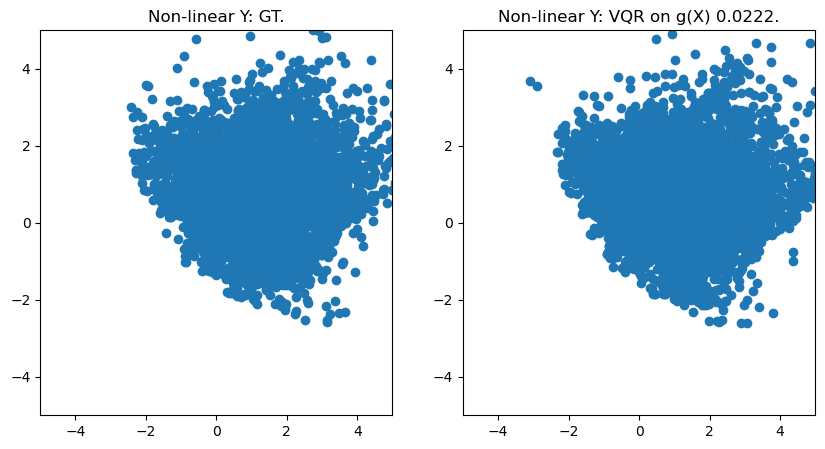

In [14]:
import ot
def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=4
    )

Y_nl_gt = zeros([n, d])
for i in range(n):
    Y_hat = (B_nl_gt @ g(X_new[i, :][:, None])) + A_nl_gt
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, 50), randint(0, 50)
    Y_nl_gt[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[0].set_title("Non-linear Y: GT.")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl_gt[:, 0], Y_nl_gt[:, 1])
ax[1].set_title(f"Non-linear Y: VQR on g(X) {w2(Y_nl, Y_nl_gt):.4f}.")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [12]:
from vqr.vqr import NonlinearRVQRDualLSESolver
import pickle

with open("nonlin-y.pkl", "wb") as f:
    pickle.dump({'X': X_new, 'Y': Y_nl}, f)